In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

# Data loading and preprocessing

In the beginning we will load the dataset and have a first, descriptive look at what is inside. We don't need the UID, as it is already in the pandas index and has no predictive power.


In [2]:
df = pd.read_csv("../data/ai4i2020.csv")
df = df.drop("UDI", axis="columns")
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


From the dataset description, we know that we can use 7 features as inputs for the ML model. Those are:
- product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

In [3]:
input_features = df[["Product ID", "Type", "Air temperature [K]", 
                     "Process temperature [K]", "Rotational speed [rpm]", 
                     "Torque [Nm]", "Tool wear [min]"]]
targets = df[["Machine failure", "TWF", "HDF", "PWF", "OSF", "RNF"]]

From the info command we can see, that there a no NANs in the dataset.

In [4]:
input_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 547.0+ KB


In [5]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Machine failure  10000 non-null  int64
 1   TWF              10000 non-null  int64
 2   HDF              10000 non-null  int64
 3   PWF              10000 non-null  int64
 4   OSF              10000 non-null  int64
 5   RNF              10000 non-null  int64
dtypes: int64(6)
memory usage: 468.9 KB


Now we check, if there are columns which only contain unique elements, which would also not be useful for predictions.

In [6]:
input_features.apply(lambda x: x.nunique())

Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
dtype: int64

We find, that we can also drop the Product ID, as it is just increasing. The info of the product quality is alread stored in "type".

In [7]:
input_features = input_features.drop("Product ID", axis="columns")

Finally, we can get some basic statistical insights into the dataset using the describe function.

In [8]:
input_features.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


Regarding the target variable, i.e. if the machine failed under the operating conditions, we can have a look at how often it fails.

In [9]:
print("Absolute number of machine failures")
print(targets.sum())
print("Relative number of machine failures to dataset size in %")
print(targets.sum()/len(targets)*100)

Absolute number of machine failures
Machine failure    339
TWF                 46
HDF                115
PWF                 95
OSF                 98
RNF                 19
dtype: int64
Relative number of machine failures to dataset size in %
Machine failure    3.39
TWF                0.46
HDF                1.15
PWF                0.95
OSF                0.98
RNF                0.19
dtype: float64


If we add up all of the failure modes, we also see, that the sum is large than the total number of failures. That means, multiple failure types can occur at the same time. This is proven by the next code block. At one time, even 4 failure types occur at once.

In [10]:
targets.sum(axis=1).value_counts()

0    9643
2     306
1      27
3      23
4       1
dtype: int64

# Exploratory plotting

In the first step, we visualize how the sensor data behaves over time and when machine failures occur. We can guess, that overheating (HDF) occurs, when Air and Process temperature deviate. For the other failure types it is not so obvious at first glance.

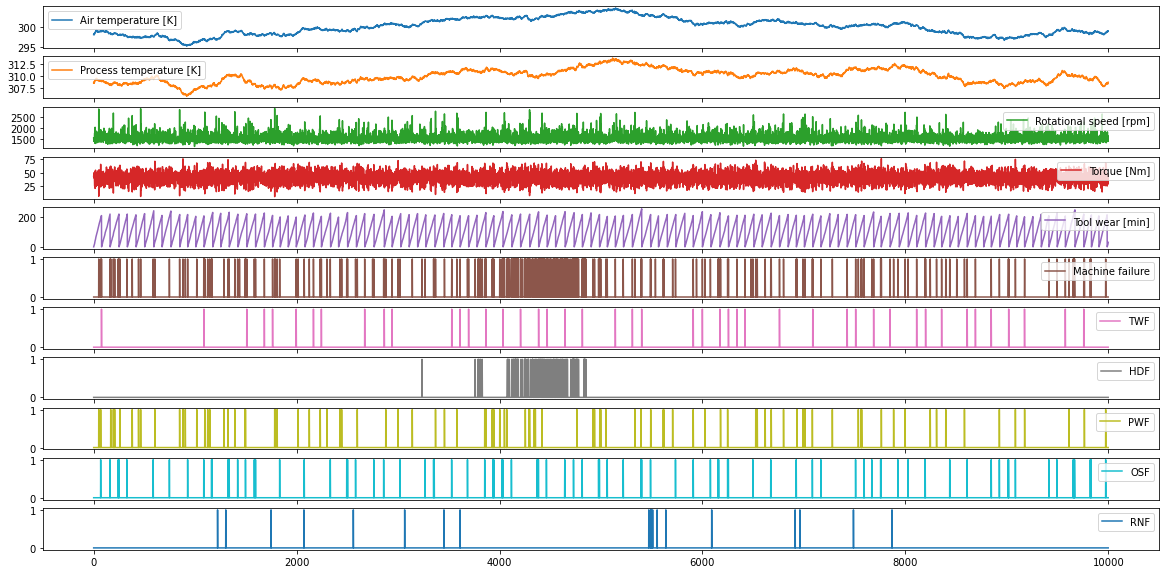

In [11]:
input_features.join(targets).plot(subplots=True, figsize=(20,10))
plt.show()